In [1]:
from analysis import Bittrex

Loading BokehJS ...

In [2]:
# instance olusturuyoruz
analysis = Bittrex()

# kullanılabilecek metodlar: 
#     .get_summary('eth')
#     .tick('eth')
#     .get_market()
#     .get_orderbook('eth')
#     .orderbook_analysis('eth', sample=10)
#     .plot('eth', loop=0, sleep=5)

In [3]:
# ilgili coin icin request anindaki son degerleri getirir
analysis.get_summary('eth')

[{'Ask': 0.0441,
  'BaseVolume': 5163.5000357,
  'Bid': 0.04390001,
  'Created': '2015-08-14T09:02:24.817',
  'High': 0.0467987,
  'Last': 0.0439,
  'Low': 0.0429,
  'MarketName': 'BTC-ETH',
  'OpenBuyOrders': 6194,
  'OpenSellOrders': 21281,
  'PrevDay': 0.0456309,
  'TimeStamp': '2017-11-20T12:52:30.83',
  'Volume': 115696.25795815}]

In [4]:
# coin icin son - alis/satis talimatinin deger bilgilerini getirir
# not : get_summary metodundaki verilerle aynidir
analysis.tick('eth')

{'Ask': 0.04415, 'Bid': 0.04390001, 'Last': 0.04390001}

In [5]:
# Bittrex uzerindeki tum coinlerin market bilgilerini getirir
analysis.get_market()

[{'BaseCurrency': 'BTC',
  'BaseCurrencyLong': 'Bitcoin',
  'Created': '2014-02-13T00:00:00',
  'IsActive': True,
  'IsSponsored': None,
  'LogoUrl': 'https://bittrexblobstorage.blob.core.windows.net/public/6defbc41-582d-47a6-bb2e-d0fa88663524.png',
  'MarketCurrency': 'LTC',
  'MarketCurrencyLong': 'Litecoin',
  'MarketName': 'BTC-LTC',
  'MinTradeSize': 0.02784181,
  'Notice': None},
 {'BaseCurrency': 'BTC',
  'BaseCurrencyLong': 'Bitcoin',
  'Created': '2014-02-13T00:00:00',
  'IsActive': True,
  'IsSponsored': None,
  'LogoUrl': 'https://bittrexblobstorage.blob.core.windows.net/public/a2b8eaee-2905-4478-a7a0-246f212c64c6.png',
  'MarketCurrency': 'DOGE',
  'MarketCurrencyLong': 'Dogecoin',
  'MarketName': 'BTC-DOGE',
  'MinTradeSize': 1388.88888889,
  'Notice': None},
 {'BaseCurrency': 'BTC',
  'BaseCurrencyLong': 'Bitcoin',
  'Created': '2014-02-13T00:00:00',
  'IsActive': True,
  'IsSponsored': None,
  'LogoUrl': 'https://bittrexblobstorage.blob.core.windows.net/public/1f0317bc-c

In [6]:
# verilen coin icin o an acik olan tum alis/satis talimalarini gosterir. 
# Quantity: coinden kac adet oldugu, Rate: BTC cinsinden talimat degeri
analysis.get_orderbook('eth')

{'buy': [{'Quantity': 13.60098526, 'Rate': 0.0439},
  {'Quantity': 64.188, 'Rate': 0.0438456},
  {'Quantity': 0.78820072, 'Rate': 0.04384559},
  {'Quantity': 0.72519741, 'Rate': 0.04384505},
  {'Quantity': 0.03738572, 'Rate': 0.04384219},
  {'Quantity': 0.17511024, 'Rate': 0.04384042},
  {'Quantity': 0.05357542, 'Rate': 0.04384007},
  {'Quantity': 0.5, 'Rate': 0.04384},
  {'Quantity': 0.32970565, 'Rate': 0.0438388},
  {'Quantity': 0.77086186, 'Rate': 0.04383574},
  {'Quantity': 0.06239305, 'Rate': 0.04383561},
  {'Quantity': 0.03667239, 'Rate': 0.04383473},
  {'Quantity': 49.74207135, 'Rate': 0.0438301},
  {'Quantity': 0.03686872, 'Rate': 0.04382997},
  {'Quantity': 0.03218603, 'Rate': 0.04382895},
  {'Quantity': 0.08884715, 'Rate': 0.04382358},
  {'Quantity': 0.89510321, 'Rate': 0.04382336},
  {'Quantity': 0.06455773, 'Rate': 0.04382279},
  {'Quantity': 0.01412532, 'Rate': 0.04381909},
  {'Quantity': 0.08495606, 'Rate': 0.04381674},
  {'Quantity': 0.09667904, 'Rate': 0.04381498},
  {'

In [7]:
# orderbook uzerinden bir deger analizi cikarilir. sample sayisi kadar son orderlar, 
# bunlarin toplami ve sample sayisi kadar orderin grafik egri degeri hesaplanir
analysis.orderbook_analysis('eth', sample=10)

{'buy_order_slope': 1343.2781607050358,
 'buy_orders': [0.001230025600188,
  0.622239453257188,
  3.4366008260571883,
  3.471159951664013,
  3.5029562683653337,
  3.5045953402048604,
  3.512272246672761,
  3.5146209968358404,
  3.5365409968358406,
  3.5509948968850606],
 'sell_order_slope': 2274.8204891798528,
 'sell_orders': [0.004882441657000001,
  0.10566874820263,
  0.22420396950765342,
  0.22621149182737843,
  0.3109365687273784,
  0.7091230287273784,
  0.7100288917785744,
  0.8569101423887344,
  0.8586236715926212,
  0.8787432848944162],
 'total_buy_orders': 3.5509948968850606,
 'total_sell_orders': 0.8787432848944162}

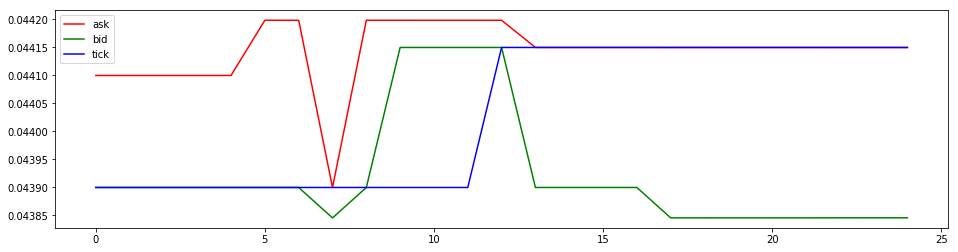

In [8]:
# coin icin anlik alis-satis talimatlari ve deger bilgileri grafigi yazdirilir. 
# loop = 0 : surekli ekrana basar, 
# loop = N : N saniye kadar calisir
# sleep = N : her bir request icin N saniye kadar bekler
analysis.plot('eth', loop=25, sleep=3)